In [1]:
import numpy as np
import pandas as pd
import os
import time
import warnings
import os
from six.moves import urllib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

import statsmodels.api  as sm

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold 

# Import the Data

In [4]:
DataFile = pd.read_csv("../input/cost-prediction-for-logistic-company/train.csv")

In [5]:
DataFile.head(2)

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649


In [6]:
DataFile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip                 38999 non-null  object 
 1   date                 38999 non-null  object 
 2   dayPart              38999 non-null  object 
 3   exWeatherTag         4882 non-null   object 
 4   originLocation       38999 non-null  object 
 5   destinationLocation  38999 non-null  object 
 6   distance             38999 non-null  int64  
 7   type                 3748 non-null   object 
 8   weight               38999 non-null  int64  
 9   packageType          2500 non-null   object 
 10  carrier              38999 non-null  object 
 11  cost                 38999 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 3.6+ MB


In [7]:
DataFile.describe()

,distance,weight,cost
count,38999.000000,38999.000000,38999.000000
mean,2004.061643,42.293033,80.972210
std,728.996843,75.473752,180.715055
min,400.000000,1.000000,5.000000
25%,1400.000000,13.000000,38.768742
50%,2000.000000,25.000000,46.468476
75%,2600.000000,39.000000,70.239797
max,3600.000000,500.000000,2019.734797


# Explore the Data

#### Split the Date to DD / MM /YY

In [8]:
date_ac = np.vstack(DataFile.date.astype(str).apply(lambda x:list(map(int,x.split('-')))).values)
DataFile['Year'] = date_ac[:,0]
DataFile['Month']= date_ac[:,1]
DataFile['Day'] = date_ac[:,2]

In [9]:
DataFile.head(4)

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost,Year,Month,Day
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152,2017,9,6
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649,2017,10,21
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939,2017,7,15
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087,2017,10,22


#### Check for the Missing Values. As they may have some insights for Visualizations

In [10]:
obs = DataFile.isnull().sum().sort_values(ascending = False)
percent = round(DataFile.isnull().sum().sort_values(ascending = False)/len(DataFile)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
packageType,36499,93.59
type,35251,90.39
exWeatherTag,34117,87.48
Day,0,0.00
Month,0,0.00
Year,0,0.00
cost,0,0.00
carrier,0,0.00
weight,0,0.00
distance,0,0.00


Weather tag could be crutial for the company - it may impact the cost. However the type and package type is also > 90% missing. For my analysis, i will drop type for now (as no business information is available), I will keep the package type and weather tag for now. 

In [11]:
DataFile = DataFile.drop(['packageType'],axis=1)

#### Impute the missing values (with "NA")

In [12]:
DataFile['type'].fillna("NA_type", inplace=True)
DataFile['exWeatherTag'].fillna("NA_Weather", inplace=True)

In [13]:
DataFile.head(5)

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,carrier,cost,Year,Month,Day
0,t52712528,2017-09-06,night,NA_Weather,S4,D7,2200,expedited,50,D,68.413152,2017,9,6
1,t29859381,2017-10-21,night,NA_Weather,S8,D1,1800,NA_type,12,B,36.450649,2017,10,21
2,t25702332,2017-07-15,night,NA_Weather,S9,D5,2800,NA_type,1,B,9.057939,2017,7,15
3,t27713405,2017-10-22,day,NA_Weather,S9,D7,3200,NA_type,50,C,57.320087,2017,10,22
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NA_type,43,B,77.263777,2019,12,11


#### Check the Weight carried and Distance Traveled across months

In [14]:
weight_Aggregated = pd.DataFrame(DataFile.groupby(["Month","originLocation","destinationLocation","carrier"],sort=True)["weight"].mean()).reset_index()

In [15]:
weight_Aggregated = weight_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
weight_Aggregated = pd.DataFrame(weight_Aggregated.groupby(["carrier","Month"],sort=True)["weight"].mean()).reset_index()

weight_Aggregated.head(3)

,carrier,Month,weight
0,A,1,23.811291
1,A,2,22.668159
2,A,3,24.523689


In [16]:
Distance_Aggregated = pd.DataFrame(DataFile.groupby(["Month","originLocation","destinationLocation","carrier"],sort=True)["distance"].sum()).reset_index()

In [17]:
Distance_Aggregated = Distance_Aggregated.drop(["originLocation","destinationLocation"],axis=1)

Distance_Aggregated = pd.DataFrame(Distance_Aggregated.groupby(["carrier","Month"],sort=True)["distance"].mean()).reset_index()

Distance_Aggregated.head(4)

,carrier,Month,distance
0,A,1,21533.333333
1,A,2,20600.000000
2,A,3,21600.000000
3,A,4,21866.666667


[Text(0, 0.5, 'distance'),
 Text(0.5, 0, 'Month of the year'),
 Text(0.5, 1.0, 'Total distance travelled by different carriers across months'),
 None]

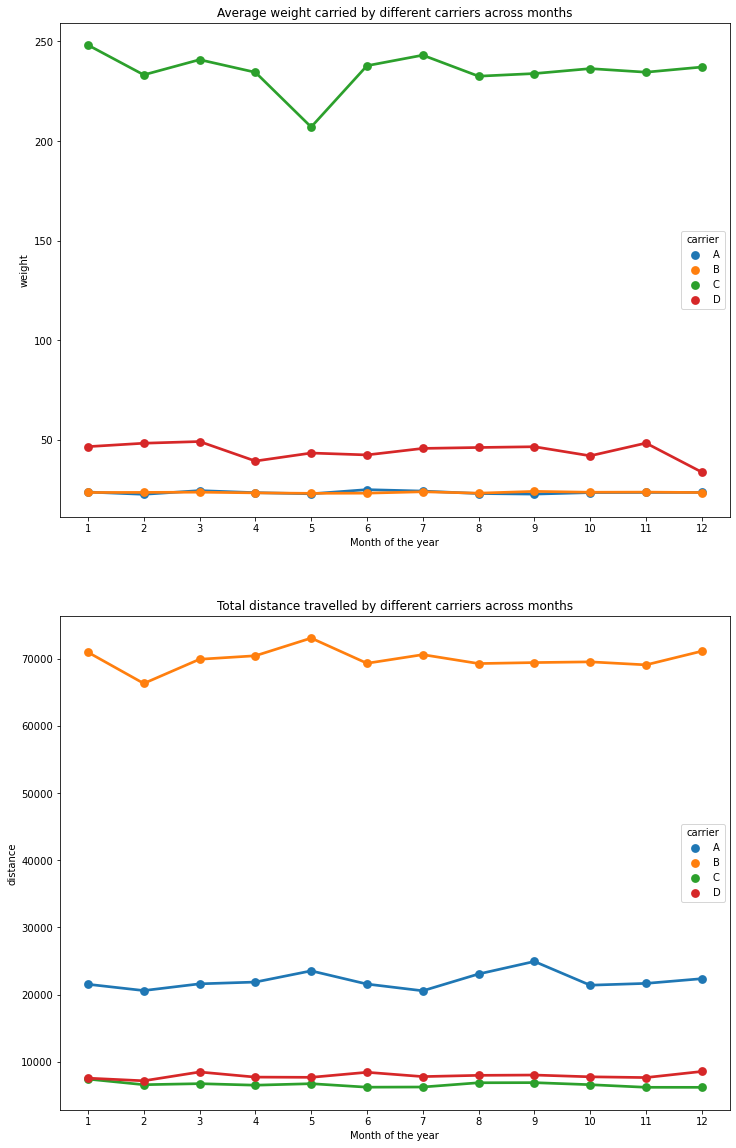

In [18]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 20)

sns.pointplot(x= weight_Aggregated["Month"], y= weight_Aggregated["weight"],hue=weight_Aggregated["carrier"], data=weight_Aggregated, join=True,ax=ax1)
ax1.set(xlabel='Month of the year', ylabel='weight',title="Average weight carried by different carriers across months",label='big')

sns.pointplot(x= Distance_Aggregated["Month"], y= Distance_Aggregated["distance"],hue=Distance_Aggregated["carrier"], data=Distance_Aggregated, join=True,ax=ax2)
ax2.set(xlabel='Month of the year', ylabel='distance',title="Total distance travelled by different carriers across months",label='big')

#### Check the Weight carried and Distance Traveled by days.

In [19]:
weight_Aggregated = pd.DataFrame(DataFile.groupby(["Day","originLocation","destinationLocation","carrier"],sort=True)["weight"].mean()).reset_index()

In [20]:
weight_Aggregated = weight_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
weight_Aggregated = pd.DataFrame(weight_Aggregated.groupby(["carrier","Day"],sort=True)["weight"].mean()).reset_index()

weight_Aggregated.head(3)

,carrier,Day,weight
0,A,1,25.105952
1,A,2,24.187053
2,A,3,23.804118


In [21]:
Distance_Aggregated = pd.DataFrame(DataFile.groupby(["Day","originLocation","destinationLocation","carrier"],sort=True)["distance"].sum()).reset_index()

In [22]:
Distance_Aggregated = Distance_Aggregated.drop(["originLocation","destinationLocation"],axis=1)

Distance_Aggregated = pd.DataFrame(Distance_Aggregated.groupby(["carrier","Day"],sort=True)["distance"].sum()).reset_index()

Distance_Aggregated.head(4)

,carrier,Day,distance
0,A,1,58800
1,A,2,45600
2,A,3,50800
3,A,4,42400


[Text(0, 0.5, 'distance'),
 Text(0.5, 0, 'Day of Month'),
 Text(0.5, 1.0, 'Total distance travelled by different carriers across days'),
 None]

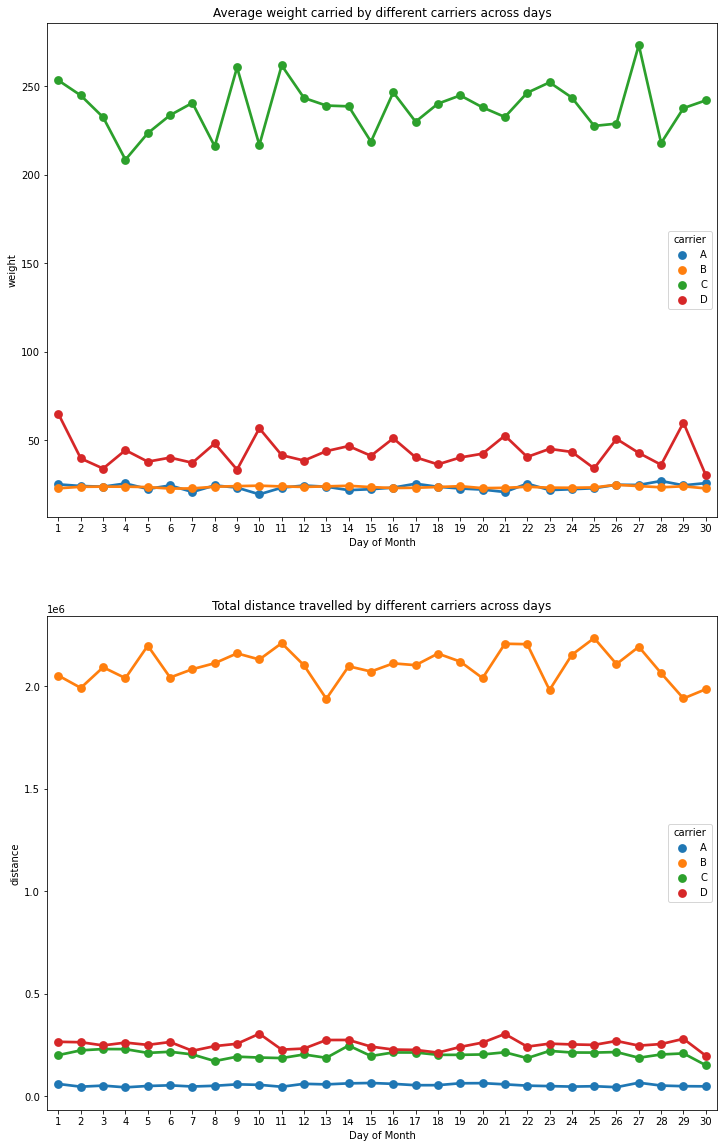

In [23]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 20)

sns.pointplot(x= weight_Aggregated["Day"], y= weight_Aggregated["weight"],hue=weight_Aggregated["carrier"], data=weight_Aggregated, join=True,ax=ax1)
ax1.set(xlabel='Day of Month', ylabel='weight',title="Average weight carried by different carriers across days",label='big')

sns.pointplot(x= Distance_Aggregated["Day"], y= Distance_Aggregated["distance"],hue=Distance_Aggregated["carrier"], data=Distance_Aggregated, join=True,ax=ax2)
ax2.set(xlabel='Day of Month', ylabel='distance',title="Total distance travelled by different carriers across days",label='big')

Carrier C has been most productive by carrying most of the goods (weights) across the time. it has also travelled lesser distance compared to Carrier D and B. This means carrier is an important feature, we can further use one hot encoding.

#### Check the Weight carried and Distance Traveled during day/night by different carriers for different Months.

In [24]:
daypart_Weight_Aggregated = pd.DataFrame(DataFile.groupby(["Month","originLocation","destinationLocation","carrier","dayPart"],sort=True)["weight"].mean()).reset_index()

In [25]:
daypart_distance_Aggregated = pd.DataFrame(DataFile.groupby(["Month","originLocation","destinationLocation","carrier","dayPart"],sort=True)["distance"].sum()).reset_index()

In [26]:
daypart_Weight_Aggregated = daypart_Weight_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
daypart_Weight_Aggregated = pd.DataFrame(daypart_Weight_Aggregated.groupby(["dayPart","Month","carrier"],sort=True)["weight"].mean()).reset_index()

daypart_Weight_Aggregated.head(3)

,dayPart,Month,carrier,weight
0,day,1,A,25.294172
1,day,1,B,24.678230
2,day,1,C,273.114286


In [27]:
daypart_distance_Aggregated = daypart_distance_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
daypart_distance_Aggregated = pd.DataFrame(daypart_distance_Aggregated.groupby(["dayPart","Month","carrier"],sort=True)["distance"].sum()).reset_index()

daypart_distance_Aggregated.head(3)

,dayPart,Month,carrier,distance
0,day,1,A,39800
1,day,1,B,1747400
2,day,1,C,159400


[Text(0, 0.5, 'distance'),
 Text(0.5, 0, 'Month of the year'),
 Text(0.5, 1.0, 'Total distance travelled by different carriers during day / night across months'),
 None]

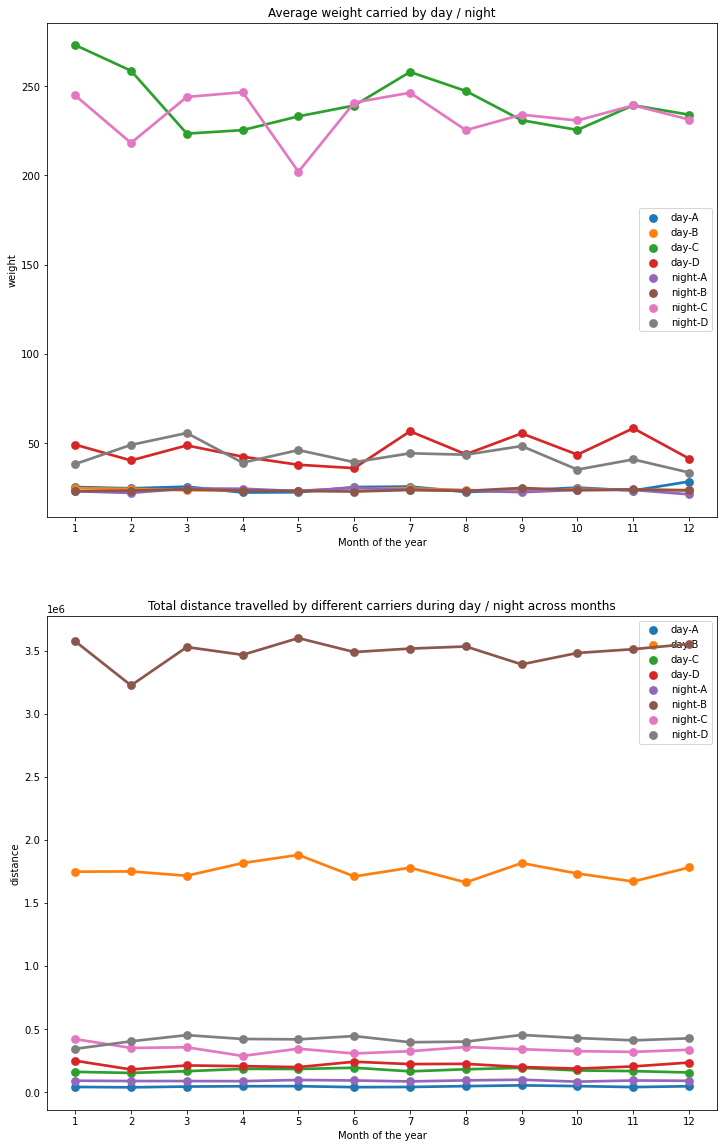

In [28]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 20)

sns.pointplot(x= daypart_Weight_Aggregated["Month"], y= daypart_Weight_Aggregated["weight"],hue=(daypart_Weight_Aggregated["dayPart"]+"-"+daypart_Weight_Aggregated["carrier"]), data=daypart_Weight_Aggregated, join=True,ax=ax1)
ax1.set(xlabel='Month of the year', ylabel='weight',title="Average weight carried by day / night",label='big')

sns.pointplot(x= daypart_distance_Aggregated["Month"], y= daypart_distance_Aggregated["distance"],hue=(daypart_distance_Aggregated["dayPart"]+"-"+daypart_distance_Aggregated["carrier"]), data=daypart_distance_Aggregated, join=True,ax=ax2)
ax2.set(xlabel='Month of the year', ylabel='distance',title="Total distance travelled by different carriers during day / night across months",label='big')

From the last graphs, we knew that Career "B" travelled the most, they travelled the most during nights, compared to days. Thus day/night is a useful feature

#### Check the Weights and Distance travelled during snow / heat in effect for days

In [29]:
weather_Weight_Aggregated = pd.DataFrame(DataFile.groupby(["Day","originLocation","destinationLocation","carrier","dayPart","exWeatherTag"],sort=True)["weight"].mean()).reset_index()

In [30]:
weather_distance_Aggregated = pd.DataFrame(DataFile.groupby(["Day","originLocation","destinationLocation","carrier","dayPart","exWeatherTag"],sort=True)["distance"].sum()).reset_index()

In [31]:
#Filter out the blank rows
exWeatherTag = ['NA_Weather']
weather_Weight_Aggregated = weather_Weight_Aggregated[~weather_Weight_Aggregated.exWeatherTag.isin(exWeatherTag)].reset_index()

In [32]:
weather_Weight_Aggregated = weather_Weight_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
weather_Weight_Aggregated = pd.DataFrame(weather_Weight_Aggregated.groupby(["carrier","Day","exWeatherTag"],sort=True)["weight"].mean()).reset_index()

weather_Weight_Aggregated.head(3)

,carrier,Day,exWeatherTag,weight
0,A,1,heat,35.000
1,A,1,snow,22.375
2,A,2,heat,32.250


In [33]:
#Filter out the blank rows
exWeatherTag = ['NA_Weather']
weather_distance_Aggregated = weather_distance_Aggregated[~weather_distance_Aggregated.exWeatherTag.isin(exWeatherTag)].reset_index()

In [34]:
weather_distance_Aggregated = weather_distance_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
weather_distance_Aggregated = pd.DataFrame(weather_distance_Aggregated.groupby(["carrier","Day","exWeatherTag"],sort=True)["distance"].sum()).reset_index()

weather_distance_Aggregated.head(3)

,carrier,Day,exWeatherTag,distance
0,A,1,heat,2800
1,A,1,snow,5400
2,A,2,heat,2400


[Text(0, 0.5, 'distance'),
 Text(0.5, 0, 'Day of the month'),
 Text(0.5, 1.0, 'Total distance travelled by different carriers during day / night (with heat/snow) across days'),
 None]

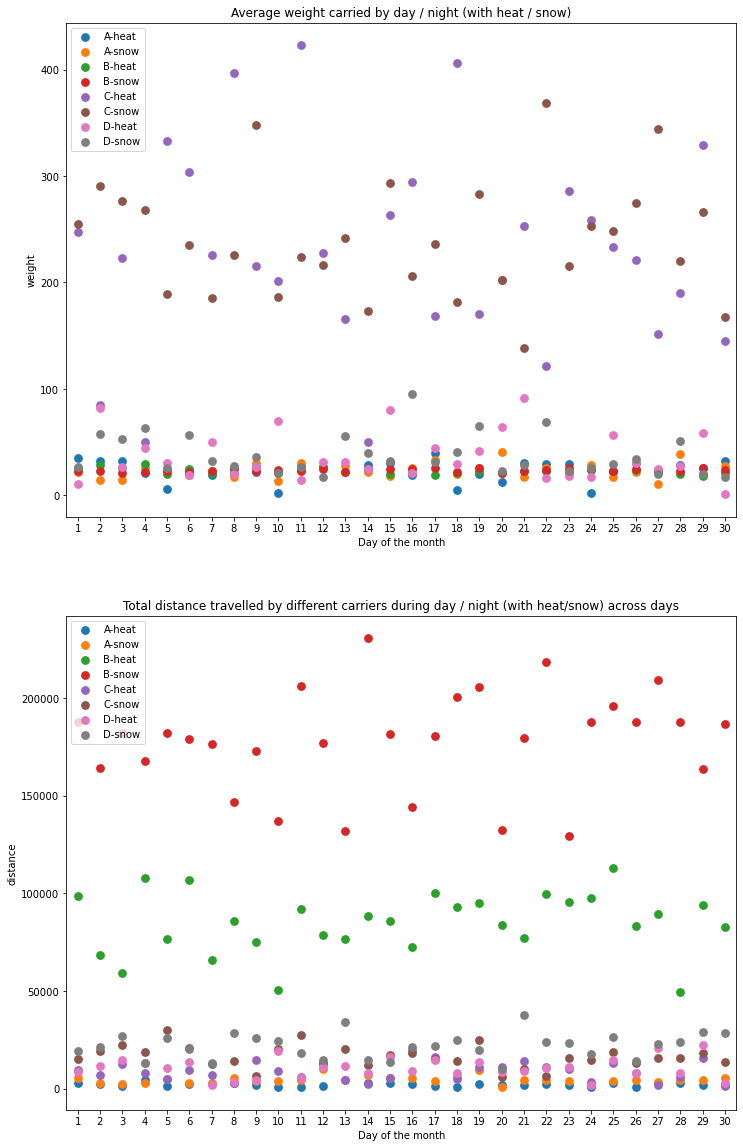

In [35]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 20)

sns.pointplot(x= weather_Weight_Aggregated["Day"], y= weather_Weight_Aggregated["weight"],hue=(weather_Weight_Aggregated["carrier"]+"-"+weather_Weight_Aggregated["exWeatherTag"]), data=weather_Weight_Aggregated,join=False,ax=ax1)
ax1.set(xlabel='Day of the month', ylabel='weight',title="Average weight carried by day / night (with heat / snow)",label='big')

sns.pointplot(x= weather_distance_Aggregated["Day"], y= weather_distance_Aggregated["distance"],hue=(weather_Weight_Aggregated["carrier"]+"-"+weather_Weight_Aggregated["exWeatherTag"]), data=weather_distance_Aggregated,join=False,ax=ax2)
ax2.set(xlabel='Day of the month', ylabel='distance',title="Total distance travelled by different carriers during day / night (with heat/snow) across days",label='big')

#### Check the Weights and Distance travelled during snow / heat in effect for months 

In [36]:
weather_Weight_Aggregated = pd.DataFrame(DataFile.groupby(["Month","originLocation","destinationLocation","carrier","dayPart","exWeatherTag"],sort=True)["weight"].mean()).reset_index()

In [37]:
weather_distance_Aggregated = pd.DataFrame(DataFile.groupby(["Month","originLocation","destinationLocation","carrier","dayPart","exWeatherTag"],sort=True)["distance"].sum()).reset_index()

In [38]:
#Filter out the blank rows
exWeatherTag = ['NA_Weather']
weather_Weight_Aggregated = weather_Weight_Aggregated[~weather_Weight_Aggregated.exWeatherTag.isin(exWeatherTag)].reset_index()

In [39]:
weather_Weight_Aggregated = weather_Weight_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
weather_Weight_Aggregated = pd.DataFrame(weather_Weight_Aggregated.groupby(["carrier","Month","exWeatherTag"],sort=True)["weight"].mean()).reset_index()

weather_Weight_Aggregated.head(3)

,carrier,Month,exWeatherTag,weight
0,A,6,heat,25.714334
1,A,12,snow,24.773027
2,B,6,heat,23.659504


In [40]:
#Filter out the blank rows
exWeatherTag = ['NA_Weather']
weather_distance_Aggregated = weather_distance_Aggregated[~weather_distance_Aggregated.exWeatherTag.isin(exWeatherTag)].reset_index()

In [41]:
weather_distance_Aggregated = weather_distance_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
weather_distance_Aggregated = pd.DataFrame(weather_distance_Aggregated.groupby(["carrier","Month","exWeatherTag"],sort=True)["distance"].sum()).reset_index()

weather_distance_Aggregated.head(3)

,carrier,Month,exWeatherTag,distance
0,A,6,heat,56600
1,A,12,snow,134200
2,B,6,heat,2544000


[Text(0, 0.5, 'distance'),
 Text(0.5, 0, 'Month of the year'),
 Text(0.5, 1.0, 'Total distance travelled by different carriers during day / night (with heat/snow) across months'),
 None]

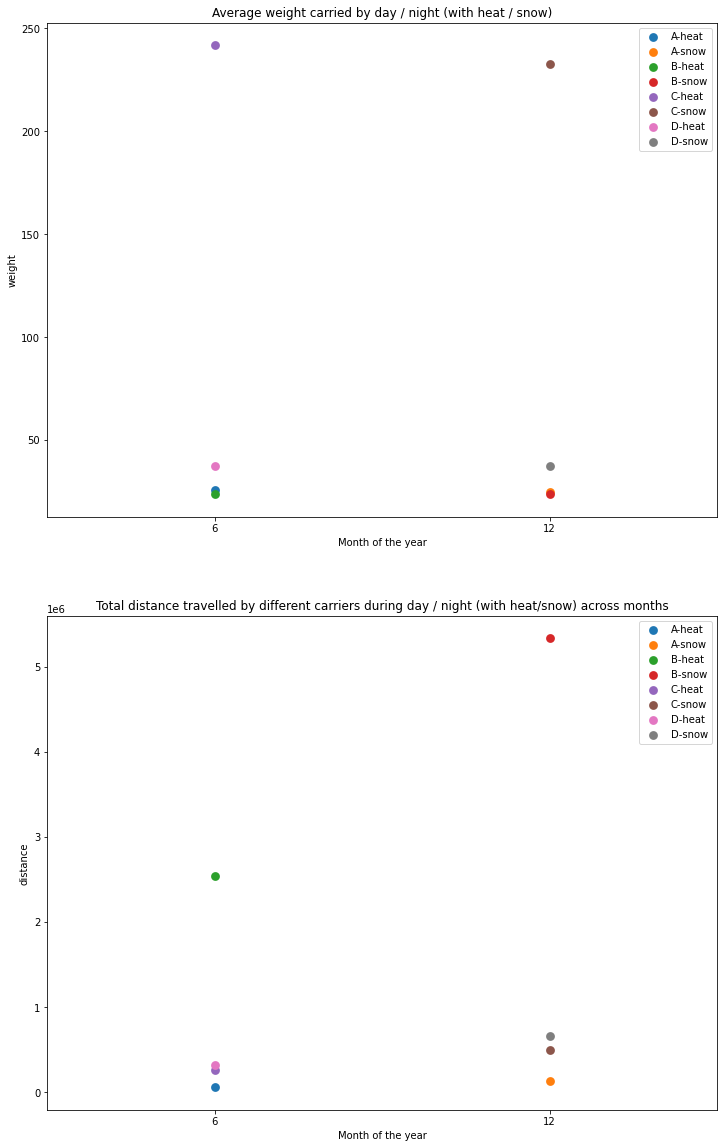

In [42]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 20)

sns.pointplot(x= weather_Weight_Aggregated["Month"], y= weather_Weight_Aggregated["weight"],hue=(weather_Weight_Aggregated["carrier"]+"-"+weather_Weight_Aggregated["exWeatherTag"]), data=weather_Weight_Aggregated,join=False,ax=ax1)
ax1.set(xlabel='Month of the year', ylabel='weight',title="Average weight carried by day / night (with heat / snow)",label='big')

sns.pointplot(x= weather_distance_Aggregated["Month"], y= weather_distance_Aggregated["distance"],hue=(weather_Weight_Aggregated["carrier"]+"-"+weather_Weight_Aggregated["exWeatherTag"]), data=weather_distance_Aggregated,join=False,ax=ax2)
ax2.set(xlabel='Month of the year', ylabel='distance',title="Total distance travelled by different carriers during day / night (with heat/snow) across months",label='big')

Analysis

While C is delivering most of the weights (as we saw before), the trend doesn't change much during 6th month (heat) and 12th month (which is cold). similarly pattern doesn't change for B in terms of distance. So heat and snow doesn't deliver any significant effect over the carriers. Month graphs, overall dont throw much insights.

##### Check the Expedite Type by Days

In [43]:
Type_Weight_Aggregated = pd.DataFrame(DataFile.groupby(["Day","originLocation","destinationLocation","carrier","type"],sort=True)["weight"].mean()).reset_index()

In [44]:
Type_distance_Aggregated = pd.DataFrame(DataFile.groupby(["Day","originLocation","destinationLocation","carrier","type"],sort=True)["distance"].sum()).reset_index()

In [45]:
#Filter out the blank rows
Type_Tag = ['NA_type']
Type_Weight_Aggregated = Type_Weight_Aggregated[~Type_Weight_Aggregated.type.isin(Type_Tag)].reset_index()

In [46]:
#Filter out the blank rows
Type_Tag = ['NA_type']
Type_distance_Aggregated = Type_distance_Aggregated[~Type_distance_Aggregated.type.isin(Type_Tag)].reset_index()

In [47]:
Type_Weight_Aggregated = Type_Weight_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
Type_Weight_Aggregated = pd.DataFrame(Type_Weight_Aggregated.groupby(["carrier","Day","type"],sort=True)["weight"].mean()).reset_index()

Type_Weight_Aggregated.head(3)

,carrier,Day,type,weight
0,D,1,expedited,64.818783
1,D,2,expedited,39.743280
2,D,3,expedited,34.040256


In [48]:
Type_distance_Aggregated = Type_distance_Aggregated.drop(["originLocation","destinationLocation"],axis=1)
Type_distance_Aggregated = pd.DataFrame(Type_distance_Aggregated.groupby(["carrier","Day","type"],sort=True)["distance"].sum()).reset_index()

Type_distance_Aggregated.head(3)

,carrier,Day,type,distance
0,D,1,expedited,264600
1,D,2,expedited,262600
2,D,3,expedited,247000


[Text(0, 0.5, 'distance'),
 Text(0.5, 0, 'Day of the month'),
 Text(0.5, 1.0, 'Total distance travelled by carrier D (with Expedite) across days'),
 None]

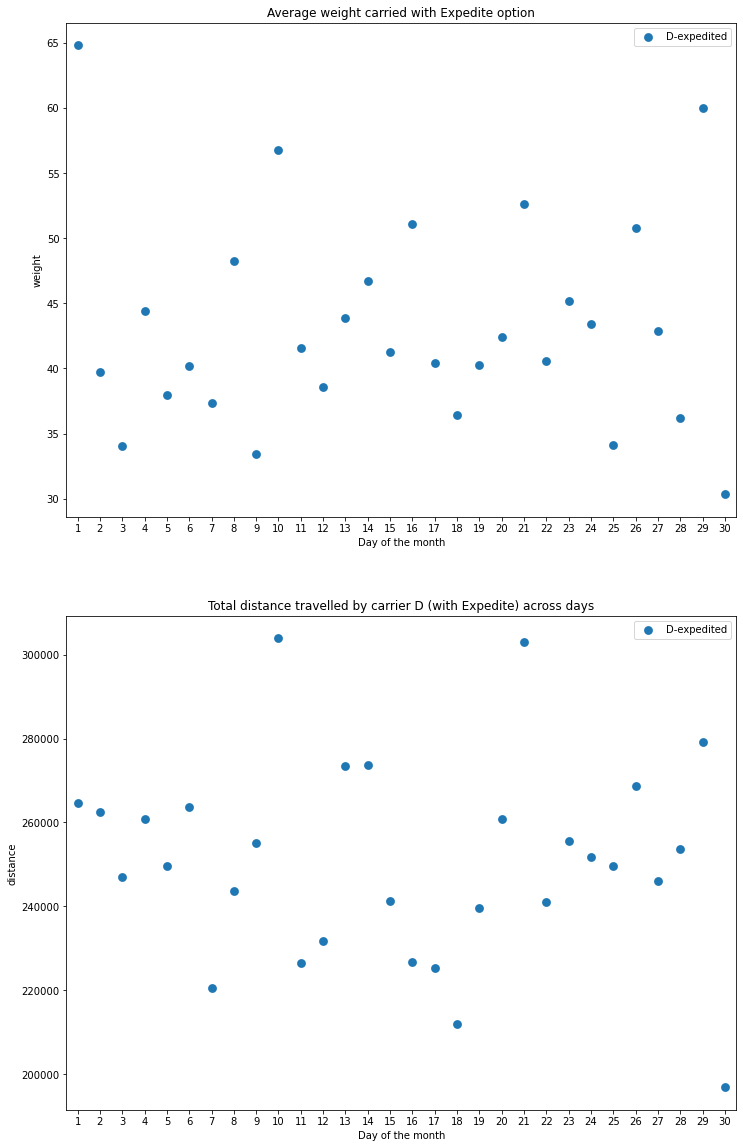

In [49]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 20)

sns.pointplot(x= Type_Weight_Aggregated["Day"], y= Type_Weight_Aggregated["weight"],hue=(Type_Weight_Aggregated["carrier"]+"-"+Type_Weight_Aggregated["type"]), data=weather_Weight_Aggregated,join=False,ax=ax1)
ax1.set(xlabel='Day of the month', ylabel='weight',title="Average weight carried with Expedite option",label='big')

sns.pointplot(x= Type_distance_Aggregated["Day"], y= Type_distance_Aggregated["distance"],hue=(Type_distance_Aggregated["carrier"]+"-"+Type_distance_Aggregated["type"]), data=weather_distance_Aggregated,join=False,ax=ax2)
ax2.set(xlabel='Day of the month', ylabel='distance',title="Total distance travelled by carrier D (with Expedite) across days",label='big')

With Expedite option only available to Carrier D, it is evident, that the career is travelling closer / lower distances with lower weights. The "Type" or Carrier D (either of two) thus could hold a significance in the model

#### Distribution of Weight across the data

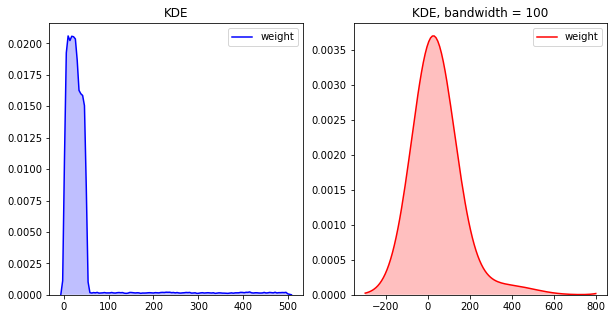

In [50]:
f, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.kdeplot(DataFile.weight, color='b', shade=True, ax=ax[0])
sns.kdeplot(DataFile.weight, color='r', shade=True, bw=100, ax=ax[1])

ax[0].set_title('KDE')
ax[1].set_title('KDE, bandwidth = 100')

plt.show()

weight is skewed towards right, it is important to either normalize the weight using standard scaler or create bins

# Feature Engineering

#### Drop the inital columns that are not needed.

In [51]:
DataFile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip                 38999 non-null  object 
 1   date                 38999 non-null  object 
 2   dayPart              38999 non-null  object 
 3   exWeatherTag         38999 non-null  object 
 4   originLocation       38999 non-null  object 
 5   destinationLocation  38999 non-null  object 
 6   distance             38999 non-null  int64  
 7   type                 38999 non-null  object 
 8   weight               38999 non-null  int64  
 9   carrier              38999 non-null  object 
 10  cost                 38999 non-null  float64
 11  Year                 38999 non-null  int64  
 12  Month                38999 non-null  int64  
 13  Day                  38999 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 4.2+ MB


In [52]:
#Create Dummy variable for daypart and type
DataFile['dayPart'].replace(['day','night'],[1,0],inplace=True)

Creating Bins for Weights and Distance Variable

In [53]:
#Making weight Bins - they were not used as they are not significant
DataFile['weight_bin'] = pd.qcut(DataFile['weight'], 5)
label = LabelEncoder()
DataFile['weight_bin'] = label.fit_transform(DataFile['weight_bin'])

In [54]:
#Making weight Bins - not used as they were not significant
DataFile['distance_bin'] = pd.qcut(DataFile['distance'], 5)
label = LabelEncoder()
DataFile['distance_bin'] = label.fit_transform(DataFile['distance_bin'])

* I remove distance bins, weight bins, origin and destination location as they were insignificant.
* Using months and days as our model variables, we can remove the year and date.
* Weather was not much significant for weights and distance, so we removed it for our analysis
* Carrier D is using expedite services, so adding type will increase correlation issue.
* trip number is insignificant
* I can now remove the weights and check if weight bins help improves the rmse (metric used for model). Bins is an ordinal variable here.

In [55]:
DataFile = DataFile.drop(['trip','date',"weight_bin","distance_bin",'originLocation','destinationLocation','exWeatherTag','type','Year'],axis=1)

In [56]:
DataFile.head(5)

,dayPart,distance,weight,carrier,cost,Month,Day
0,0,2200,50,D,68.413152,9,6
1,0,1800,12,B,36.450649,10,21
2,0,2800,1,B,9.057939,7,15
3,1,3200,50,C,57.320087,10,22
4,1,2000,43,B,77.263777,12,11


In [57]:
DataFile.shape

(38999, 7)

In [58]:
train_set, val_set = train_test_split(DataFile, test_size=0.10,shuffle=False)

In [59]:
# Now define x and y.

#the Y Variable
train_set_y = train_set["cost"].copy()
val_set_y = val_set["cost"].copy()

#the X variables
train_set_X = train_set.drop("cost", axis=1)
val_set_X = val_set.drop("cost", axis=1)

In [60]:
# Reference from Hands on Machine learning - one of my text books!
# The CategoricalEncoder class will allow us to convert categorical attributes to one-hot vectors.

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [61]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [62]:
cat_pipeline = Pipeline([
        ("selector", DataFrameSelector(['carrier'])),
        ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])

num_pipeline = Pipeline([
        ("selector", DataFrameSelector(['distance','weight'])),
        ('std_scaler', MinMaxScaler()),
      ])

no_pipeline = Pipeline([
        ("selector", DataFrameSelector(["dayPart","Month","Day"]))
    ])

y_pipeline = Pipeline([
        ("selector", DataFrameSelector(['cost'])),
        ('std_scaler', StandardScaler()),
      ])

In [63]:
full_pipeline = FeatureUnion(transformer_list=[
    ("no_pipeline", no_pipeline),
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
    ])

final_train_X = full_pipeline.fit_transform(train_set_X)
final_val_X = full_pipeline.transform(val_set_X)

final_train_y = y_pipeline.fit_transform(pd.DataFrame(train_set_y))
final_val_y = y_pipeline.transform(pd.DataFrame(val_set_y))

Good Luck for the Competition!